In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

# Import data

In [2]:
df = pd.read_csv("data/data_for_distribution.csv")

In [3]:
df.head()

,Unique_ID,holeid,from,to,As,Au,Pb,Fe,Mo,Cu,S,Zn,Class
0,A04812,SOLVE003,561,571.0,NaN,0.066,1031.00,61380.0,138.2000,3.600,3586.0000,43.6000,A
1,A03356,SOLVE003,571,581.0,NaN,0.152,1982.00,50860.0,75.4000,4.800,1822.0000,36.4000,A
2,A04764,SOLVE003,581,591.0,NaN,0.068,1064.80,57940.0,29.2000,3.000,740.4000,36.6000,A
3,A04626,SOLVE003,591,601.0,NaN,0.074,891.60,48620.0,63.0000,4.200,820.8000,39.6000,A
4,A05579,SOLVE003,601,611.0,NaN,0.043125,801.25,51025.0,56.0625,4.875,745.6875,32.3125,A


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4771 entries, 0 to 4770
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Unique_ID  4771 non-null   object 
 1   holeid     4771 non-null   object 
 2   from       4771 non-null   int64  
 3   to         4771 non-null   float64
 4   As         3268 non-null   float64
 5   Au         4765 non-null   object 
 6   Pb         4756 non-null   float64
 7   Fe         4709 non-null   float64
 8   Mo         4741 non-null   float64
 9   Cu         4746 non-null   float64
 10  S          4761 non-null   float64
 11  Zn         4762 non-null   float64
 12  Class      4771 non-null   object 
dtypes: float64(8), int64(1), object(4)
memory usage: 484.7+ KB


In [5]:
df.shape

(4771, 13)

In [6]:
df.isna().sum()

Unique_ID       0
holeid          0
from            0
to              0
As           1503
Au              6
Pb             15
Fe             62
Mo             30
Cu             25
S              10
Zn              9
Class           0
dtype: int64

In [7]:
df_duplicate = df[df.duplicated()]

In [8]:
df_duplicate

,Unique_ID,holeid,from,to,As,Au,Pb,Fe,Mo,Cu,S,Zn,Class


# Dealing with missing data and unsuitable detection limits

In [9]:
#As data have maximum missing data, probably leave it now and delete missing data in other columns
df_new = df[(df["Au"].isna()==False) & 
                 (df["Pb"].isna()==False) & 
                 (df["Fe"].isna()==False) & 
                 (df["Mo"].isna()==False) & 
                 (df["Cu"].isna()==False) & 
                 (df["S"].isna()==False) & 
                 (df["Zn"].isna()==False)] 
                 #(df["As"].isna()==False)

In [10]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4643 entries, 0 to 4770
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Unique_ID  4643 non-null   object 
 1   holeid     4643 non-null   object 
 2   from       4643 non-null   int64  
 3   to         4643 non-null   float64
 4   As         3187 non-null   float64
 5   Au         4643 non-null   object 
 6   Pb         4643 non-null   float64
 7   Fe         4643 non-null   float64
 8   Mo         4643 non-null   float64
 9   Cu         4643 non-null   float64
 10  S          4643 non-null   float64
 11  Zn         4643 non-null   float64
 12  Class      4643 non-null   object 
dtypes: float64(8), int64(1), object(4)
memory usage: 507.8+ KB


In [11]:
df_new1 = df_new.replace("<0.005", 0)

In [12]:
#Here I replace it with 0, with can possibly replace it with the detection limit
df_new2 = df_new1.replace(-999, 0)

In [13]:
#Au = "<0.005"
#Mo = -999
#check if there is any unsuitable data
df_new2.query("Au == '<0.005'")
df_new2.isna().sum()

Unique_ID       0
holeid          0
from            0
to              0
As           1456
Au              0
Pb              0
Fe              0
Mo              0
Cu              0
S               0
Zn              0
Class           0
dtype: int64

In [14]:
df_new2["Au"] = df_new2["Au"].astype("float")

In [15]:
df_new2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4643 entries, 0 to 4770
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Unique_ID  4643 non-null   object 
 1   holeid     4643 non-null   object 
 2   from       4643 non-null   int64  
 3   to         4643 non-null   float64
 4   As         3187 non-null   float64
 5   Au         4643 non-null   float64
 6   Pb         4643 non-null   float64
 7   Fe         4643 non-null   float64
 8   Mo         4643 non-null   float64
 9   Cu         4643 non-null   float64
 10  S          4643 non-null   float64
 11  Zn         4643 non-null   float64
 12  Class      4643 non-null   object 
dtypes: float64(9), int64(1), object(3)
memory usage: 507.8+ KB


In [16]:
#Separate the labelled data with unlabelled data
df_unlabel = df_new2[df_new2["Class"] == "?"]
df_label = df_new2[df_new2["Class"] != "?"]

# Explore data

In [17]:
feature_mean  = list(df_label.columns[4:])

In [18]:
mean_corr = df_label[feature_mean].corr()
mean_corr

,As,Au,Pb,Fe,Mo,Cu,S,Zn
As,1.000000,0.098881,0.032181,0.311665,-0.095757,0.058420,0.520986,0.132987
Au,0.098881,1.000000,0.530294,0.142030,0.118958,0.070418,0.056632,0.166795
Pb,0.032181,0.530294,1.000000,0.268606,0.316486,0.041102,0.068862,0.066277
Fe,0.311665,0.142030,0.268606,1.000000,0.052365,0.016937,0.405561,0.093456
Mo,-0.095757,0.118958,0.316486,0.052365,1.000000,0.031355,-0.046401,0.038299
Cu,0.058420,0.070418,0.041102,0.016937,0.031355,1.000000,0.039730,0.666360
S,0.520986,0.056632,0.068862,0.405561,-0.046401,0.039730,1.000000,0.082276
Zn,0.132987,0.166795,0.066277,0.093456,0.038299,0.666360,0.082276,1.000000


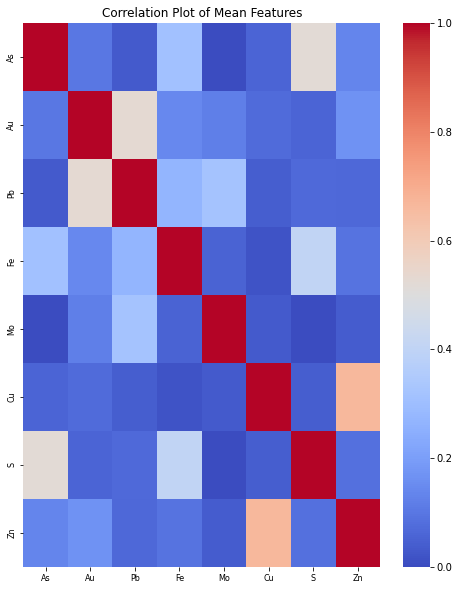

In [19]:
#plot realationship figure of different features
fig=plt.figure(figsize=(8,10))
g1 = sns.heatmap(mean_corr, cmap='coolwarm', vmin=0, vmax=1)
g1.set_xticklabels(g1.get_xticklabels(), fontsize=8)
g1.set_yticklabels(g1.get_yticklabels(), fontsize=8)
plt.title("Correlation Plot of Mean Features")
plt.show()

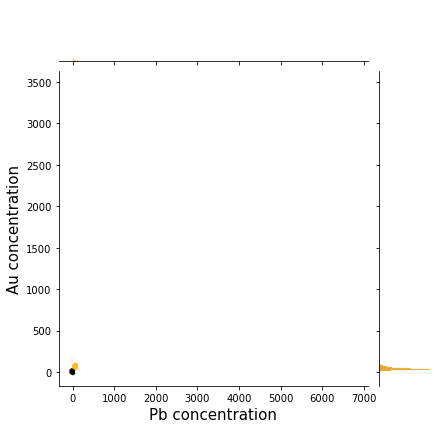

In [20]:
g2 = sns.jointplot(x=df_label['Cu'], y=df_label['Zn'], kind='hex', color='orange')
g2.set_axis_labels('Pb concentration', 'Au concentration', fontsize=15)
plt.show()

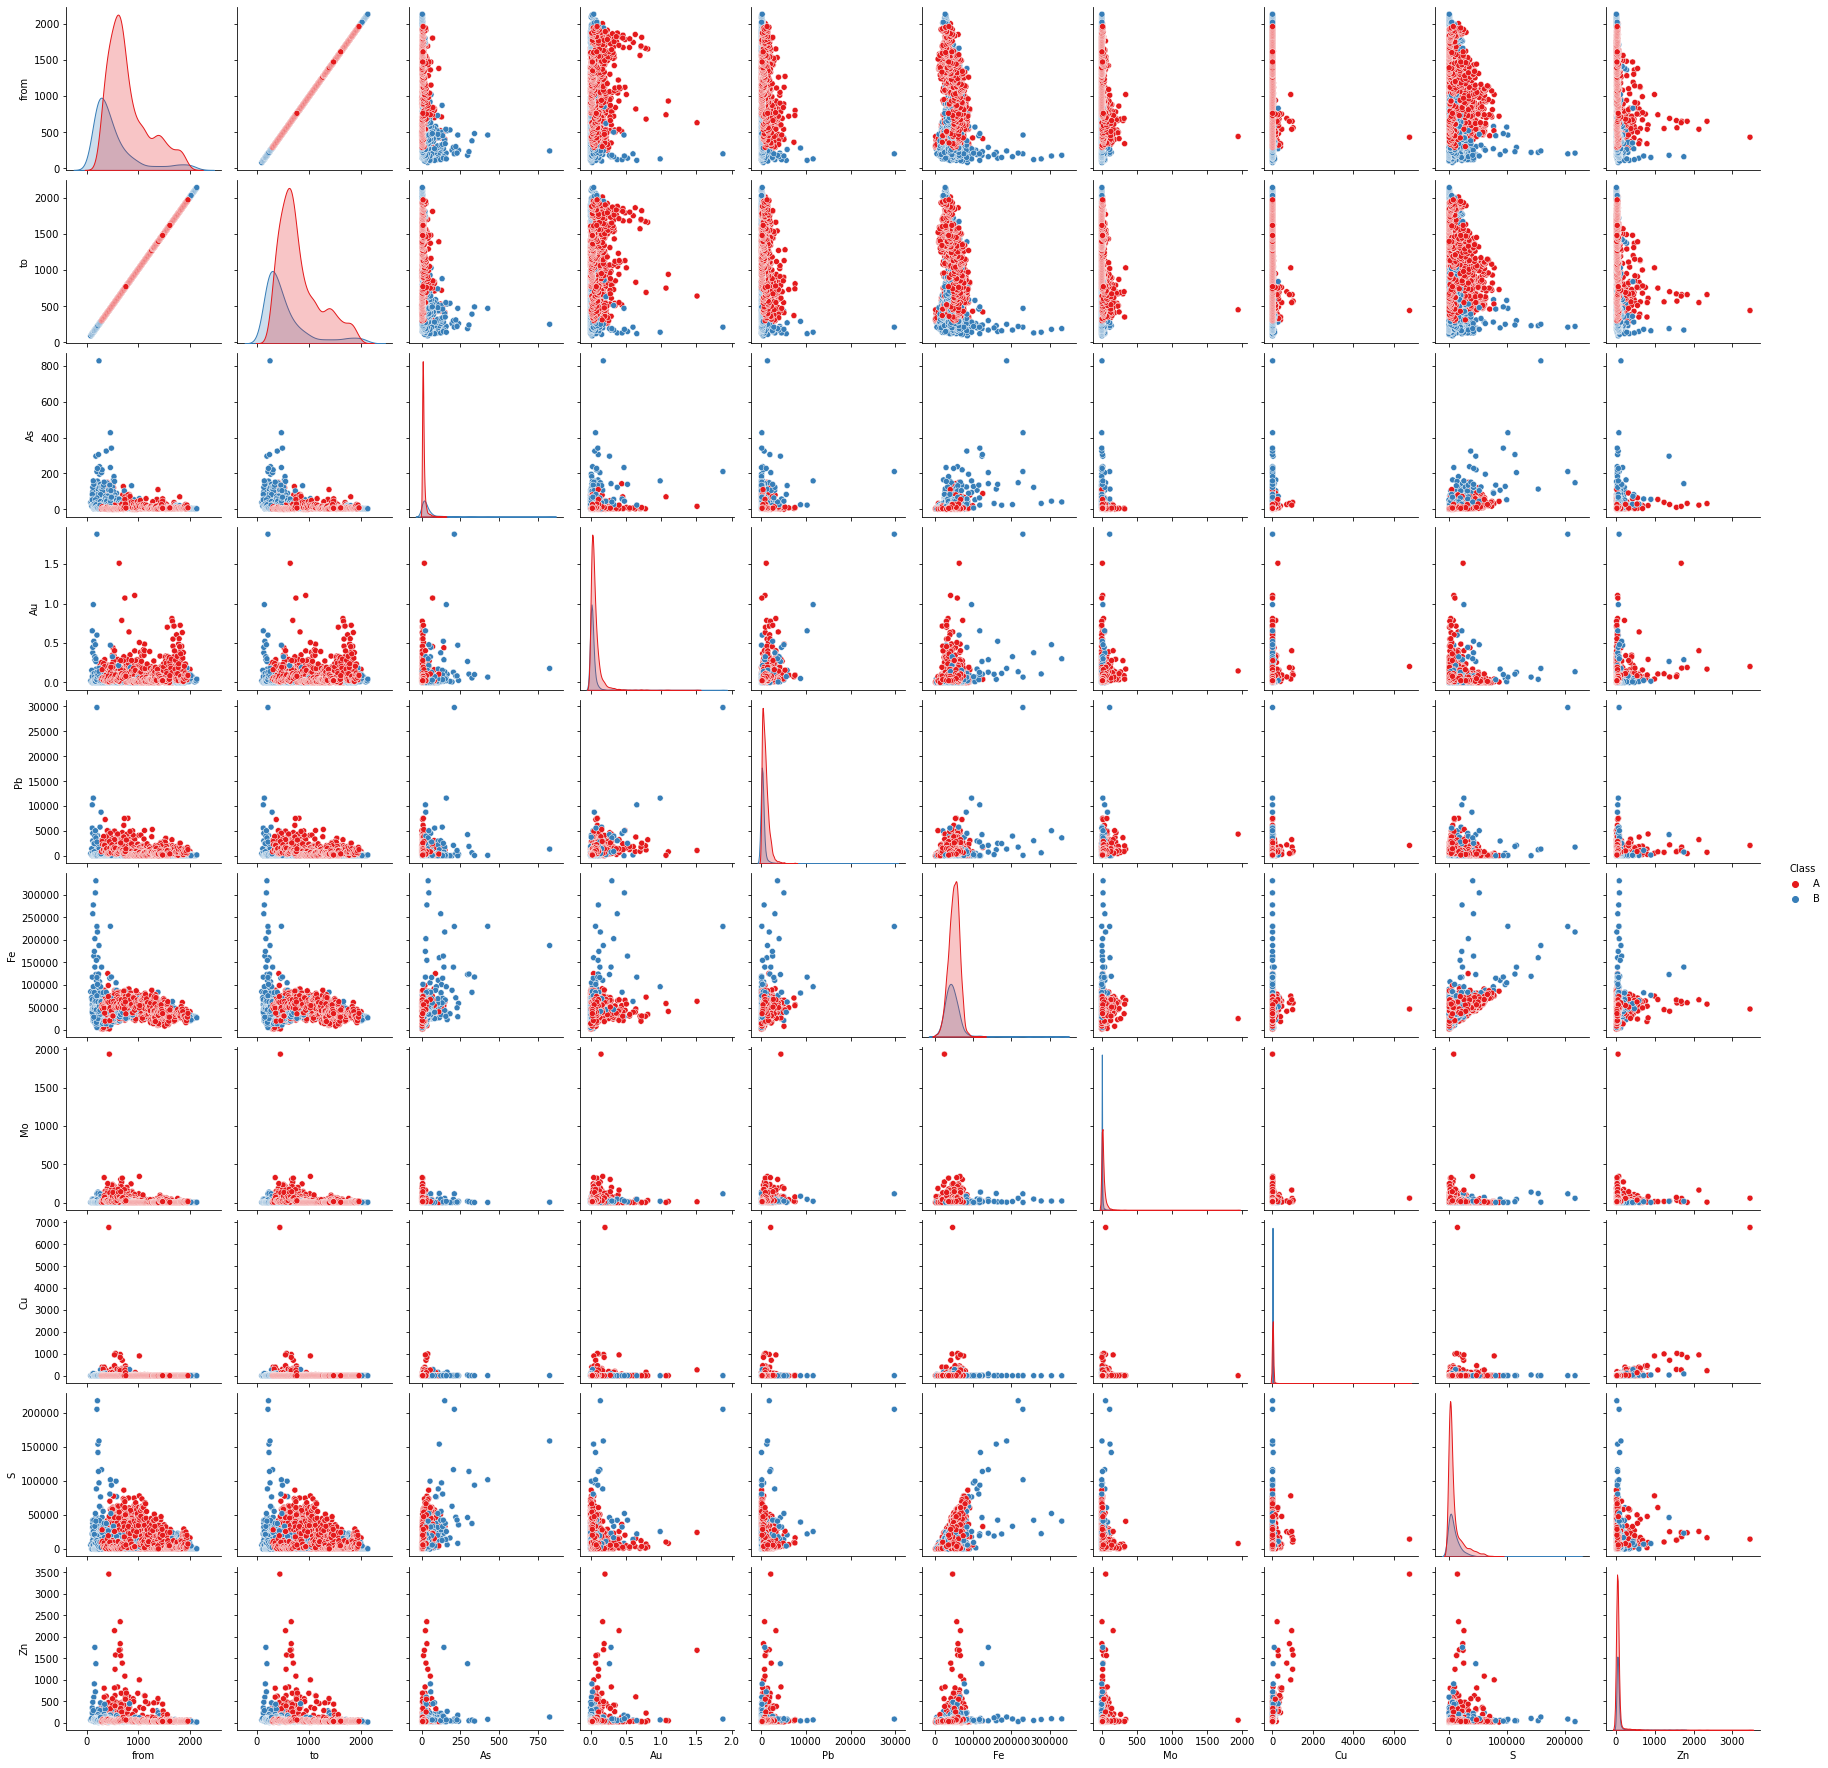

In [21]:
sns.pairplot(df_label,hue='Class',palette="Set1",diag_kind="auto")

# Machine learning

In [22]:
#Separate the columns into features and targets
#it starts from column5, because As have many missing data, we just ignore it now
features=df_label.iloc[:,5:-1]
targets=df_label["Class"]

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(features, targets, test_size=0.20, 
                                                    stratify=targets, random_state=40, shuffle=True)

print ("train feature shape: ", X_train.shape)
print ("test feature shape: ", X_test.shape)

train feature shape:  (3124, 7)
test feature shape:  (781, 7)


In [24]:
# For PCA, First Need to Scale the Data.  
scaler1 = StandardScaler()
scaler1.fit(features)
feature_scaled = scaler1.transform(features)

# Now Apply PCA
pca1 = PCA(n_components=4)
pca1.fit(feature_scaled)
feature_scaled_pca = pca1.transform(feature_scaled)
print("shape of the scaled and 'PCA'ed features: ", np.shape(feature_scaled_pca))

shape of the scaled and 'PCA'ed features:  (3905, 4)


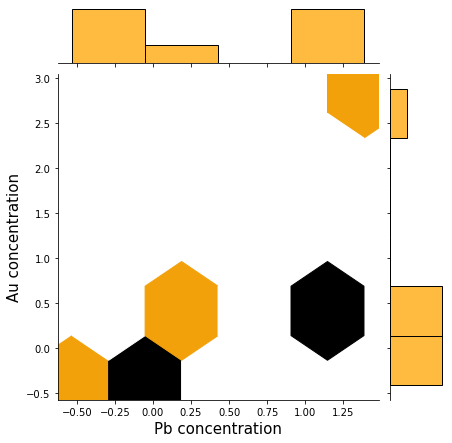

In [25]:
#I used ‘hex’ setting. Darker the hexagon, more number of points fall in that region (data is discrete)
g3 = sns.jointplot(x=feature_scaled[1], y=feature_scaled[0], kind='hex', color='orange')
g3.set_axis_labels('Pb concentration', 'Au concentration', fontsize=15)
plt.show()

In [26]:
pca1.explained_variance_ratio_

array([0.28315193, 0.21958069, 0.18411262, 0.12550099])

In [27]:
# Let's see the variance to see out of the 
# 4 components which are contributing most 
feat_var = np.var(feature_scaled_pca, axis=0)
feat_var_rat = feat_var/(np.sum(feat_var))
print ("Variance Ratio of the 4 Principal Components Ananlysis: ", feat_var_rat)

Variance Ratio of the 4 Principal Components Ananlysis:  [0.34856065 0.27030431 0.22664304 0.154492  ]


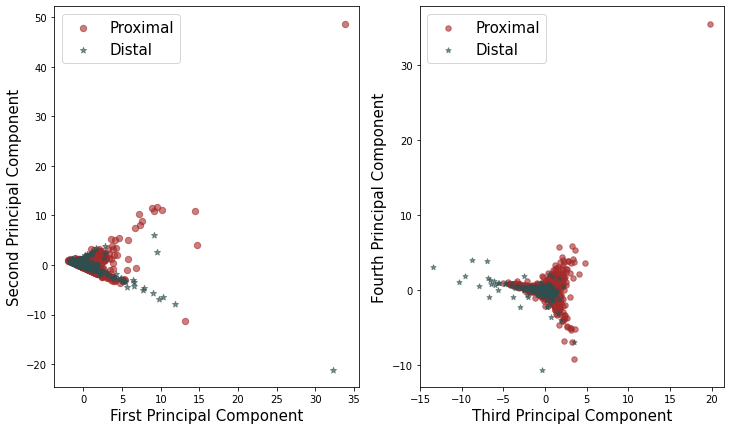

In [28]:
#plot the components and see how separated the samples are
#Different labeled samples are overlapping
feature_scaled_pca_X0 = feature_scaled_pca[:, 0]
feature_scaled_pca_X1 = feature_scaled_pca[:, 1]
feature_scaled_pca_X2 = feature_scaled_pca[:, 2]
feature_scaled_pca_X3 = feature_scaled_pca[:, 3]

labels = targets.tolist()
colordict = {"A":'brown', "B":'darkslategray'}
piclabel = {"A":'Proximal', "B":'Distal'}
markers = {"A":'o', "B":'*'}
alphas = {"A":0.6, "B":0.6}

fig = plt.figure(figsize=(12, 7))
plt.subplot(1,2,1)
for l in list(np.unique(labels)):
    ix = [x for x in range(len(labels)) if labels[x] == l]
    plt.scatter(feature_scaled_pca_X0[ix], feature_scaled_pca_X1[ix], c=colordict[l], 
               label=piclabel[l], s=40, marker=markers[l], alpha=alphas[l])
plt.xlabel("First Principal Component", fontsize=15)
plt.ylabel("Second Principal Component", fontsize=15)

plt.legend(fontsize=15)

plt.subplot(1,2,2)
for l1 in np.unique(labels):
    ix1 = [x for x in range(len(labels)) if labels[x] == l1]
    plt.scatter(feature_scaled_pca_X2[ix1], feature_scaled_pca_X3[ix1], c=colordict[l1], 
               label=piclabel[l1], s=30, marker=markers[l1], alpha=alphas[l1])

plt.xlabel("Third Principal Component", fontsize=15)
plt.ylabel("Fourth Principal Component", fontsize=15)

plt.legend(fontsize=15)

plt.show()

In [29]:
#As seen above, the data are overlapped with each other and data are not separated
# Pipeline Steps are StandardScaler, PCA and SVM 
#A set of parameters to run the model
pipe_steps = [('scaler', StandardScaler()), ('pca', PCA()), ('SupVM', SVC(kernel='rbf'))]
check_params= {
    'pca__n_components': [4], 
    'SupVM__C': [10, 50, 75, 100, 150, 200, 500, 700, 1000, 12000], # used [0.1, 0.5, 1, 10,30, 40, 50, 75, 100, 500, 1000]
    'SupVM__gamma' : [0.05, 0.07, 0.1, 0.5, 1, 1.5, 2, 5] # used [0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50]
}

pipeline = Pipeline(pipe_steps)

In [30]:
#Create gridsearchcv to run the model
#As we can see, the cross-validation score for 4 and 5 times are round the same as 0.8
#It may worthwhile to tune the k_params

import warnings
warnings.filterwarnings("ignore")
print ("Start Fitting Training Data")
for cv in tqdm(range(4,6)):
    create_grid = GridSearchCV(pipeline, param_grid=check_params, cv=cv)
    create_grid.fit(X_train, Y_train)
    print ("score for %d fold CV := %3.2f" %(cv, create_grid.score(X_test, Y_test)))
    print ("Best-Fit Parameters From Training Data:")
    print (create_grid.best_params_)

print ("out of the loop")

Start Fitting Training Data


  0%|          | 0/2 [00:00<?, ?it/s]

score for 4 fold CV := 0.82
Best-Fit Parameters From Training Data:
{'SupVM__C': 1000, 'SupVM__gamma': 0.1, 'pca__n_components': 4}
score for 5 fold CV := 0.82
Best-Fit Parameters From Training Data:
{'SupVM__C': 200, 'SupVM__gamma': 0.07, 'pca__n_components': 4}
out of the loop


In [31]:
print ("grid best params: ", create_grid.best_params_) 
# use the best one

grid best params:  {'SupVM__C': 200, 'SupVM__gamma': 0.07, 'pca__n_components': 4}


0.8220230473751601
Confusion Matrix: 

[[512  45]
 [ 94 130]]


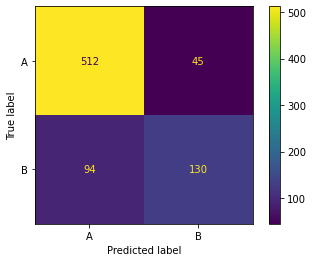

In [32]:
# Time for Prediction and Plotting Confusion Matrix
Y_pred = create_grid.predict(X_test)
score1 = accuracy_score(Y_test,Y_pred)
print(score1)
# print (Y_pred)
cm1 = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix: \n")
print(cm1)

cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = ["A", "B"])
cm1_display.plot()
plt.show()

In [33]:
# Now it is time to predict the label of new data
predict_list1 = create_grid.predict(df_unlabel.iloc[:,5:-1])

In [34]:
predict_list1.shape

(738,)

In [35]:
#Let's check the random forest method now
#Scale values, create the ML classifier with numerical data
rf = Pipeline(steps=[('scaler', StandardScaler()), ('classifier', RandomForestClassifier(random_state=1))])

In [36]:
rf

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=1))])

In [37]:
print('Tranining the Clasifier...')
rf.fit(X_train, Y_train)

print("Done RF. Now scoring...")
scores = cross_val_score(rf, X_test, Y_test, cv=5)

print("RF 5-fold cross validation Scores:", scores)
print("SCORE Mean: %.2f" % np.mean(scores), "STD: %.2f" % np.std(scores), "\n")

# plt.plot(Y_test.values,'b-', label='Target (expected)')
# plt.plot(rf.predict(X_test), 'rx',label='Prediction')
# plt.xlabel("Feature set")
# plt.ylabel("Target/Prediction")
# plt.legend(loc=7)

Tranining the Clasifier...
Done RF. Now scoring...
RF 5-fold cross validation Scores: [0.8089172  0.82051282 0.84615385 0.87820513 0.78205128]
SCORE Mean: 0.83 STD: 0.03 



0.8220230473751601
Confusion Matrix: 

[[517  40]
 [ 86 138]]


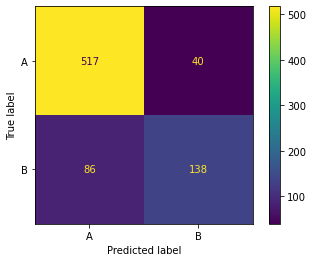

In [38]:
# Time for Prediction and Plotting Confusion Matrix
Y_pred2 = rf.predict(X_test)
score2 = accuracy_score(Y_test,Y_pred2)
print(score1)
# print (Y_pred)
cm2 = confusion_matrix(Y_test, Y_pred2)
print("Confusion Matrix: \n")
print(cm2)

cm2_display = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = ["A", "B"])
cm2_display.plot()
plt.show()

In [39]:
# Gather the importance measures
ft_imp=[]
ft_lab=[]
numfts = df.columns[5:-1]
for i,lab in enumerate(numfts):
    ft_imp.append(rf.steps[-1][1].feature_importances_[i])
    ft_lab.append(lab)

In [40]:
rf.steps[-1][1].feature_importances_

array([0.1108932 , 0.25394675, 0.13047999, 0.16005354, 0.08680866,
       0.13588338, 0.12193447])

From the Random Forest ML algorithm
these are the the most significant features for predicting the target bins.



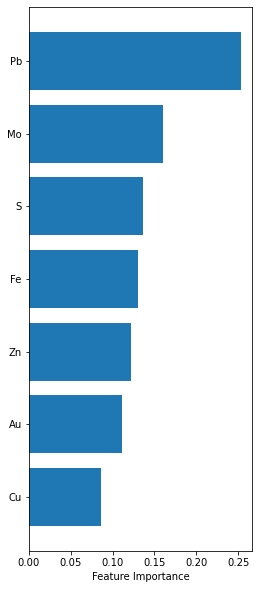

In [41]:
#Make the bar plot
ft_imps, ft_labs = (list(t) for t in zip(*sorted(zip(ft_imp,ft_lab))))
datalength=len(ft_imp)

#Create a new figure
fig,ax = plt.subplots(figsize=(4,10))

#Plot the bar graph
rects=ax.barh(np.arange(0, datalength, step=1),ft_imps)
ax.set_yticks(np.arange(0, datalength, step=1))
ax.set_yticklabels(ft_labs)
ax.set_xlabel('Feature Importance')
print("From the Random Forest ML algorithm\nthese are the the most significant features for predicting the target bins.\n")

plt.show()

In [42]:
#Time to predict new data label
#Apply the trained ML to our gridded data to determine the probabilities at each of the points
print('RF...')
pRF_map=np.array(rf.predict_proba(df_unlabel.iloc[:,5:-1]))
print("Done RF")

RF...
Done RF


In [43]:
pRF_map

array([[0.96, 0.04],
       [1.  , 0.  ],
       [1.  , 0.  ],
       ...,
       [0.65, 0.35],
       [0.49, 0.51],
       [0.64, 0.36]])

In [44]:
predict_list2 =[]

for item in pRF_map:
    if item[0] > item[1]:
        predict_list2.append("A")
    else:
        predict_list2.append("B")

In [45]:
len(predict_list2)

738

# Summary

In [46]:
df_unlabel["P_Class1"] = predict_list1
df_unlabel["P_Class2"] = predict_list2

In [47]:
df_unlabel[df_unlabel["P_Class1"] != df_unlabel["P_Class2"]]

,Unique_ID,holeid,from,to,As,Au,Pb,Fe,Mo,Cu,S,Zn,Class,P_Class1,P_Class2
4023,A05063,SOLVE225W1,1531,1541.0,23.0,0.058,106.0,25780.0,2.6,3.6,5740.0,22.4,?,A,B
4025,A04625,SOLVE225W1,1551,1561.0,19.8,0.074,151.2,29380.0,1.6,5.0,9600.0,18.6,?,A,B
4041,A04819,SOLVE225W2,1641,1651.0,3.0,0.066,112.2,26400.0,1.0,4.6,2620.0,17.6,?,A,B
4043,A05328,SOLVE225W2,1661,1671.0,4.6,0.050,158.0,28960.0,1.0,3.8,780.0,17.0,?,A,B
4057,A07143,SOLVE226,281,291.0,39.0,0.016,34.2,37280.0,73.6,4.0,5980.0,61.8,?,A,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4753,A03456,SOLVE291,1151,1161.0,9.6,0.144,187.6,52300.0,3.0,3.0,2920.0,40.0,?,A,B
4758,A06514,SOLVE291,1201,1211.0,10.6,0.025,86.4,43760.0,1.8,3.0,2640.0,24.2,?,B,A
4763,A07672,SOLVE291,1251,1261.0,7.8,0.010,77.0,46480.0,1.4,3.0,2400.0,35.2,?,B,A
4769,A07560,SOLVE291,1311,1321.0,10.0,0.011,109.6,55460.0,2.6,4.0,5700.0,33.4,?,A,B


In [48]:
#1. We can take As into consideration
#2. Change the model parameters to see if we can get better results